# Proyecto integrador 1
## Proyecto de analisis de imagenes
## Integrantes:

   - Juliana Ochoa Ramirez
   - Javier Arturo Rozo Alzate
   - Mateo Graciano
   - Cristian David Muñoz Mora
   - Juan Mauricio Cuscagua López
 

## Librerias usadas en el proyecto y funciones creadas utiles

In [41]:
import cv2 # Lee las imagenes jpg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from skimage.measure import  compare_ssim
from collections import Counter
import pandas as pd


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['faces','outliers']#classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)


# Lectura y preprocesamiento de datos

In [2]:
#List all image files
import glob
image_list = []
base1='input/faces94/*'
male=[]
female=[]
n_im=0
for root1 in glob.glob(base1):
    base2=root1+'/*'
    for (root2) in glob.glob(base2):
        base3=root2+'/*.jpg'
        for (root3) in glob.glob(base3):
            image_list.append(root3)
            if('/male/'in root3):
                male.append(n_im)
            if('/female/'in root3):
                female.append(n_im)
            if('/malestaff/'in root3):
                male.append(n_im)
            n_im+=1

# Make a whole matrix with all dataset 180x180*num_images
data_set=np.zeros((len(image_list),180,180))
data_set_vec=np.zeros((180*180,len(image_list)))
for image in range(len(image_list)):
    data_set[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(image_list[image]),(180, 180)),cv2.COLOR_BGR2GRAY)
    data_set_vec[:,image]=np.reshape(data_set[image,:,:], (-1))
outlier_list = []
base1='input/Outliers/*'
for root1 in glob.glob(base1):
    outlier_list.append(root1)
    
data_set_out=np.zeros((len(outlier_list),180,180))
data_set_out_vec=np.zeros((180*180,len(outlier_list)))
for image in range(len(outlier_list)):
    data_set_out[image,:,:]=cv2.cvtColor(cv2.resize(cv2.imread(outlier_list[image]),(180, 180)),cv2.COLOR_BGR2GRAY)
    data_set_out_vec[:,image]=np.reshape(data_set_out[image,:,:], (-1))


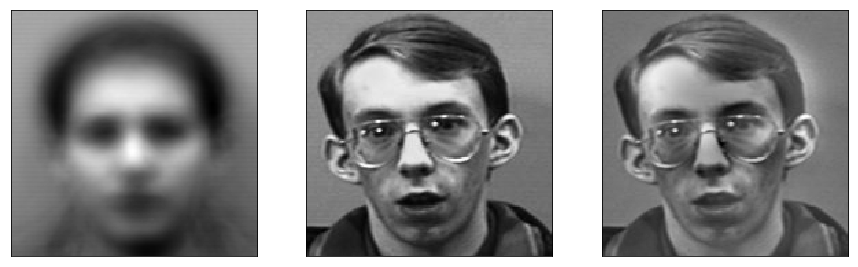

In [3]:
plt.rcParams['figure.figsize'] = [15,5]
data_set_vec_mean=np.reshape(np.mean(data_set_vec,axis=1),(-1,1))
data_no_mean=data_set_vec-data_set_vec_mean
fig, axs = plt.subplots(nrows=1, ncols=3)
axs[0].imshow(np.reshape(data_set_vec_mean,(180,180)), cmap = plt.cm.gray)
axs[0].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')

axs[1].imshow(np.reshape(data_set_vec[:,2500],(180,180)), cmap = plt.cm.gray)
axs[1].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')

axs[2].imshow(np.reshape(data_no_mean[:,2500],(180,180)), cmap = plt.cm.gray)
axs[2].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')


## Calculando los eigenvectors y values de $AA^{T}$

In [4]:
matrix_trick=np.dot(data_no_mean.transpose(),data_no_mean)

#eigenvalues, eigenvectors, = np.linalg.eig(matrix_trick)

eigenvectors, eigenvalues, eigenvectors = np.linalg.svd(matrix_trick)

eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

#Sort the eigen pairs in descending order:
#eig_pairs.sort()
#eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
#eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

# Varianza explicada en función de eigenvectors escogidos

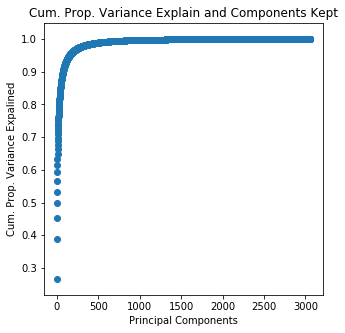

In [5]:

plt.rcParams['figure.figsize'] = [5,5]
var_comp_sum = np.cumsum(eigenvalues)/sum(eigenvalues);

num_comp = range(1,len(eigenvalues)+1);
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

# Identificación de outliers: Incluyendolos desde el comienzo

In [6]:
data_set_aum_vec=np.append(data_set_vec,data_set_out_vec,axis=1)
data_set_aum_vec_mean=np.reshape(np.mean(data_set_aum_vec,axis=1),(-1,1))
data_aum_no_mean=data_set_aum_vec-data_set_aum_vec_mean

matrix_trick=np.dot(data_aum_no_mean.transpose(),data_aum_no_mean)

eigenvectors, eigenvalues, eigenvectors = np.linalg.svd(matrix_trick)

eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
#eig_pairs.sort(reverse=True)
#eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
#eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

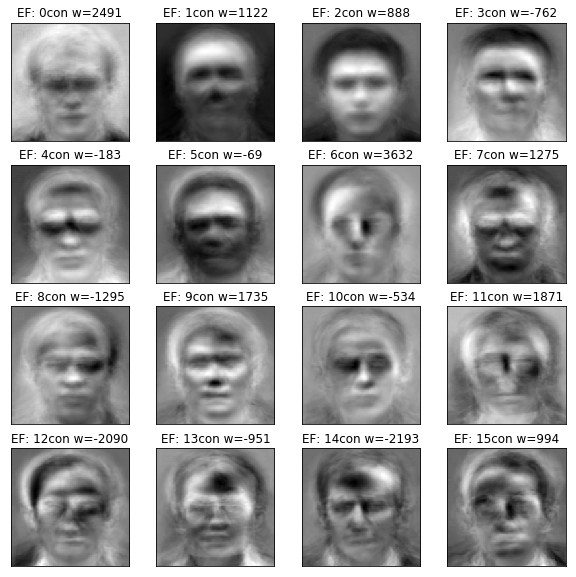

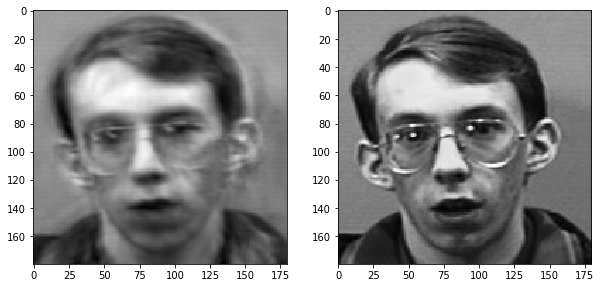

In [7]:
reduced_eig = np.array(eigenvectors[:100]).transpose()
eig_face = np.dot(data_aum_no_mean,reduced_eig)
eig_face = eig_face.transpose()

for i in range(eig_face.shape[0]):
    eig_face[i,:]=eig_face[i,:]/np.linalg.norm(eig_face[i,:],ord=None)

W=np.dot(eig_face,data_aum_no_mean)



plt.rcParams['figure.figsize'] = [10,10]

foto=2500
foto_rec=data_set_vec_mean.copy()

fig, axs = plt.subplots(nrows=4, ncols=4)
for i in range(eig_face.shape[0]):
    foto_rec+=W[i,foto]*np.reshape(eig_face[i,:],foto_rec.shape)
    f=int(i/4)
    c=i%4
    if (i<16):
        axs[f,c].imshow(np.reshape(eig_face[i,:],(180,180)), cmap = plt.cm.gray) #check
        axs[f,c].set_title('EF: '+str(i)+'con w='+str(int(W[i,foto])))
        axs[f,c].tick_params(labelleft=False, labelbottom=False, bottom=False,top=False,right=False,left=False, which='both')
plt.show();


plt.rcParams['figure.figsize'] = [10,10]

fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].imshow(np.reshape(foto_rec,(180,180)), cmap = plt.cm.gray)
axs[1].imshow(np.reshape(data_set_aum_vec[:,foto],(180,180)), cmap = plt.cm.gray)
plt.show();

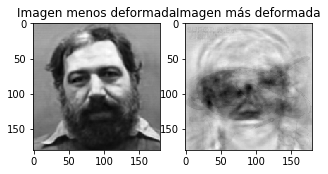

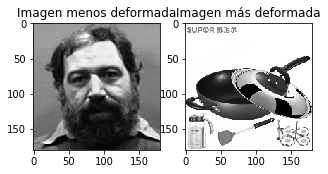

C:\Users\Juliana\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


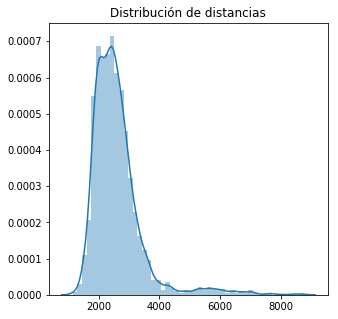

In [9]:

data_set_aum_rec=data_set_aum_vec.copy()
media=np.reshape(data_set_aum_vec_mean.copy(),data_set_aum_rec[:,1].shape)
for foto in range(data_set_aum_vec.shape[1]):
    data_set_aum_rec[:,foto]=media
    for i in range(eig_face.shape[0]):
        data_set_aum_rec[:,foto]+=W[i,foto]*np.reshape(eig_face[i,:],data_set_aum_rec[:,foto].shape)
        

plt.rcParams['figure.figsize'] = [5,5]

distances=[]
for foto in range(data_set_aum_vec.shape[1]):
    aux=data_set_aum_vec[:,foto]-data_set_aum_rec[:,foto]
    distances.append(np.linalg.norm(aux,ord=None))
    
orden=np.argsort(np.array(distances))

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(np.reshape(data_set_aum_rec[:,orden[0]],(180,180)), cmap = plt.cm.gray) #check
axs[0].set_title('Imagen menos deformada')
#plt.show()

axs[1].imshow(np.reshape(data_set_aum_rec[:,orden[-1]],(180,180)), cmap = plt.cm.gray) #check
axs[1].set_title('Imagen más deformada')
plt.show();


fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(np.reshape(data_set_aum_vec[:,orden[0]],(180,180)), cmap = plt.cm.gray) #check
axs[0].set_title('Imagen menos deformada')
#plt.show()

axs[1].imshow(np.reshape(data_set_aum_vec[:,orden[-1]],(180,180)), cmap = plt.cm.gray) #check
axs[1].set_title('Imagen más deformada')
plt.show();
    
    
sns.distplot(distances)
plt.title('Distribución de distancias')
plt.show();

Normalized confusion matrix


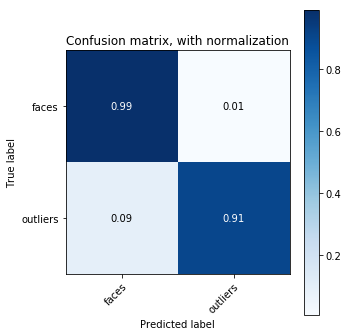

In [10]:

LI= np.percentile(distances,25)-1.5*(np.percentile(distances,75)-np.percentile(distances,25))
LS= np.percentile(distances,75)+1.5*(np.percentile(distances,75)-np.percentile(distances,25))

outliers = np.argwhere( (distances> LS))

L_Faces=np.zeros(data_set.shape[0])
L_Out=np.ones(data_set_out.shape[0])
L=np.concatenate((L_Faces,L_Out))

LOut=Counter(L[outliers[:,0]])
Outliers={"Fotos que son Outliers":LOut[0], "Verdaderos outliers": LOut[1]}
Fotos={"Verdaderas Fotos":len(data_set)-LOut[0], "Outliers que son fotos":len(data_set_out)-LOut[1]}

#print(Outliers)
#print(Fotos)

L2=np.zeros(L.shape[0])
for i in outliers:
    L2[i]=1

plot_confusion_matrix(L,L2, classes=['faces','outliers'],
                      title='Confusion matrix, with normalization')

## K-Means

In [248]:
W.shape

(100, 3188)

In [249]:
kmeans= KMeans(n_clusters=4, random_state=0).fit(W.transpose())

In [250]:
kmeans.labels_

array([0, 0, 0, ..., 2, 3, 2])

In [251]:
wcentro=kmeans.cluster_centers_
wcentro.shape

(4, 100)

In [252]:
C1=np.dot(kmeans.cluster_centers_[0],eig_face) 
C2=np.dot(kmeans.cluster_centers_[1],eig_face) 
C3=np.dot(kmeans.cluster_centers_[2],eig_face) 
#C4=np.dot(kmeans.cluster_centers_[3],eig_face) 
print(len(C1))

32400


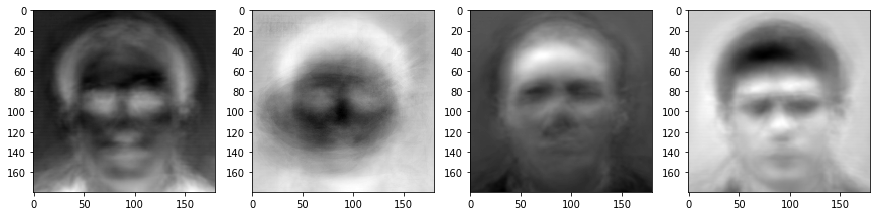

In [254]:
plt.rcParams['figure.figsize'] = [15,5]
fig, axs = plt.subplots(nrows=1, ncols=4)

axs[0].imshow(np.reshape(C1,(180,180)), cmap = plt.cm.gray)
axs[1].imshow(np.reshape(C2,(180,180)), cmap = plt.cm.gray)
axs[2].imshow(np.reshape(C3,(180,180)), cmap = plt.cm.gray)
axs[3].imshow(np.reshape(C4,(180,180)), cmap = plt.cm.gray)

plt.show();


In [265]:
ylabel=kmeans.labels_
Distances=kmeans.transform(W.transpose())
WdistCentr=np.amin(Distances, axis=1)
ordenDis=np.argsort(WdistCentr)

In [276]:
Resultado={'Clase Distancias':WdistCentr,'label':ylabel}
df = pd.DataFrame(Resultado)
df.sort_values('Clase Distancias', axis = 0, ascending = True, inplace = True, na_position ='first') 

### Clase 1

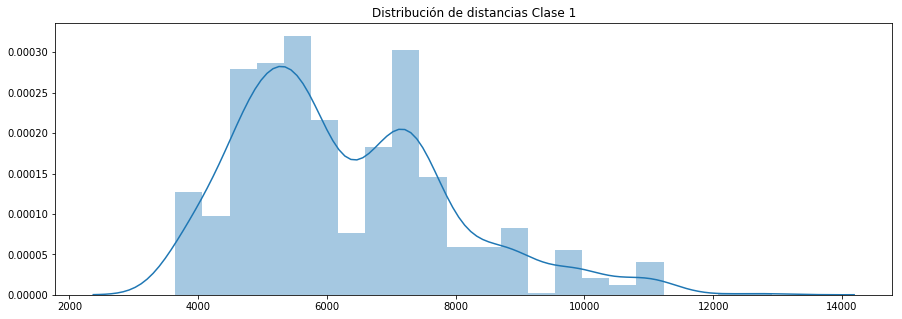

In [277]:
sns.distplot(WdistCentr[ylabel==0])
plt.title('Distribución de distancias Clase 1')
plt.show();

In [278]:
df1=df.loc[df[df.columns[1]]==0]    
df1.head()

,Clase Distancias,label
781,3643.168983,0
798,3666.802712,0
796,3671.505208,0
782,3686.656019,0
2076,3701.623243,0


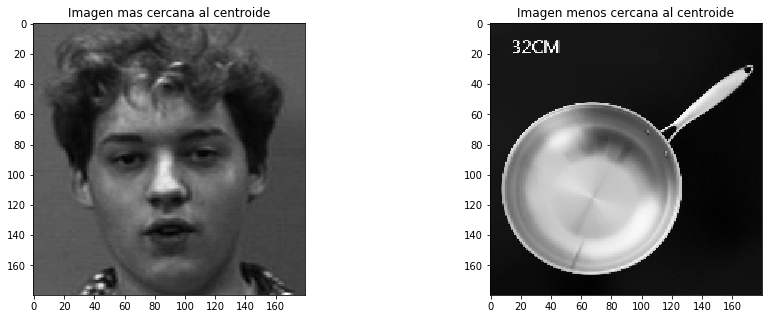

In [279]:
#menor y mayor distancias
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(np.reshape(data_set_aum_vec[:,df1.index[0]],(180,180)), cmap = plt.cm.gray) #check
axs[0].set_title('Imagen mas cercana al centroide')
#plt.show()

axs[1].imshow(np.reshape(data_set_aum_vec[:,df1.index[-1]],(180,180)), cmap = plt.cm.gray) #check
axs[1].set_title('Imagen menos cercana al centroide')
plt.show();

### Clase 2

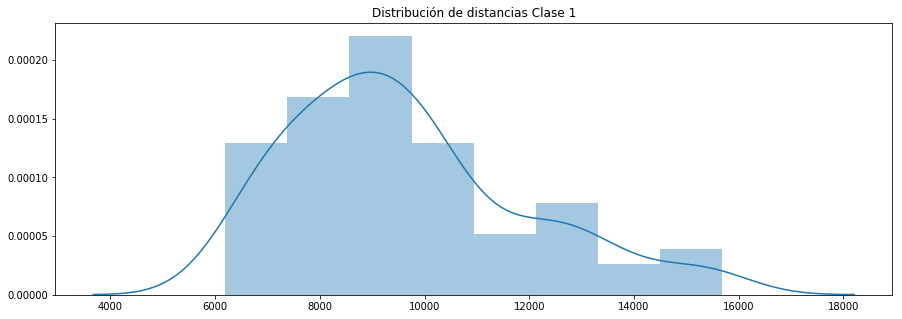

In [281]:
sns.distplot(WdistCentr[ylabel==1])
plt.title('Distribución de distancias Clase 1')
plt.show();

In [282]:
df1=df.loc[df[df.columns[1]]==1]    
df1.head()

,Clase Distancias,label
3110,6191.233822,1
3108,6474.628110,1
3078,6530.788627,1
3061,6615.504100,1
3063,6832.676029,1


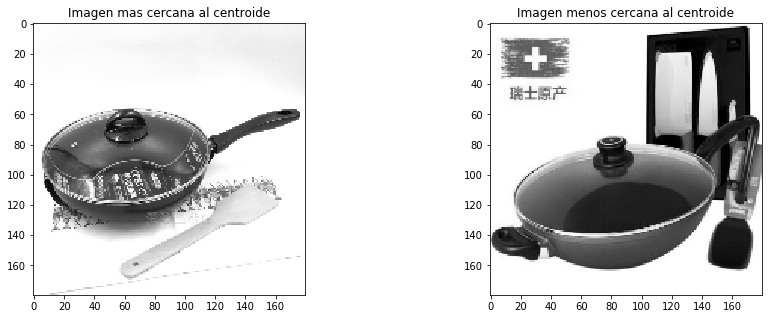

In [283]:
#menor y mayor distancias
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(np.reshape(data_set_aum_vec[:,df1.index[0]],(180,180)), cmap = plt.cm.gray) #check
axs[0].set_title('Imagen mas cercana al centroide')
#plt.show()

axs[1].imshow(np.reshape(data_set_aum_vec[:,df1.index[-1]],(180,180)), cmap = plt.cm.gray) #check
axs[1].set_title('Imagen menos cercana al centroide')
plt.show();

### Clase 3

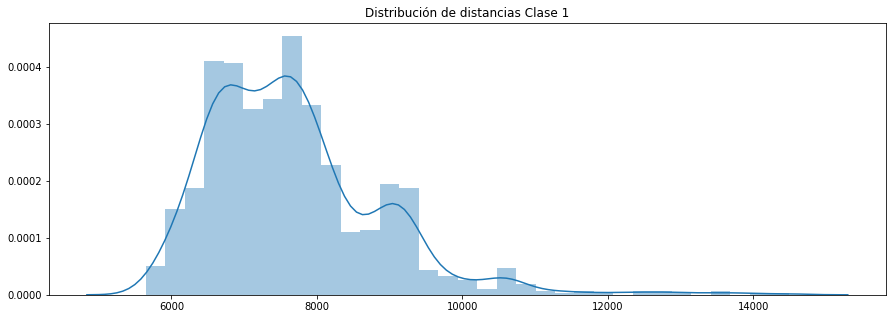

In [296]:
sns.distplot(WdistCentr[ylabel==2])
plt.title('Distribución de distancias Clase 1')
plt.show();

In [297]:
df1=df.loc[df[df.columns[1]]==2]    
df1.head()

,Clase Distancias,label
2931,5648.392919,2
901,5689.055414,2
3034,5741.813146,2
3033,5753.326425,2
902,5780.704343,2


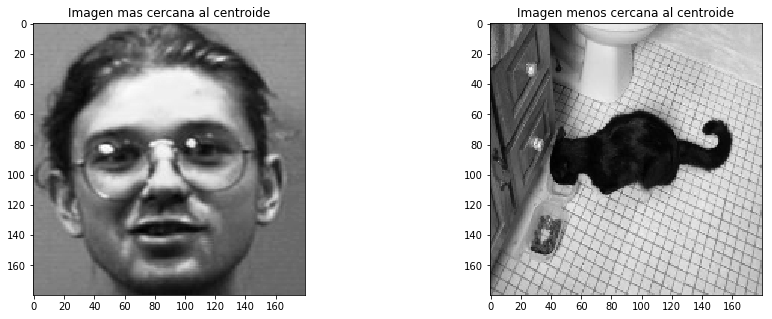

In [298]:
#menor y mayor distancias
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(np.reshape(data_set_aum_vec[:,df1.index[0]],(180,180)), cmap = plt.cm.gray) #check
axs[0].set_title('Imagen mas cercana al centroide')
#plt.show()

axs[1].imshow(np.reshape(data_set_aum_vec[:,df1.index[-1]],(180,180)), cmap = plt.cm.gray) #check
axs[1].set_title('Imagen menos cercana al centroide')
plt.show();

### Clase 4

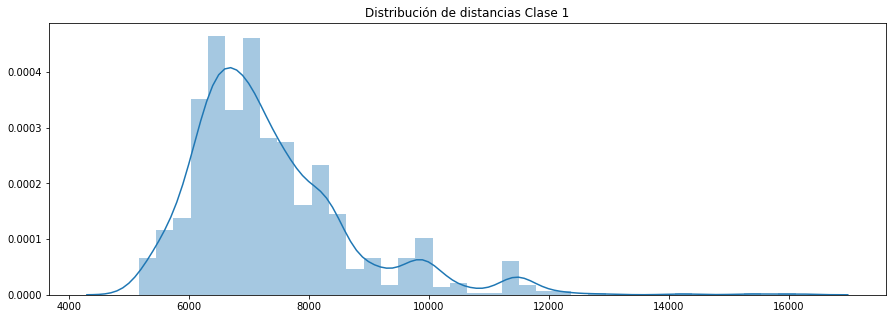

In [293]:
sns.distplot(WdistCentr[ylabel==3])
plt.title('Distribución de distancias Clase 1')
plt.show();

In [299]:
df1=df.loc[df[df.columns[1]]==3]    
df1.head()

,Clase Distancias,label
1941,5165.995509,3
1956,5166.975542,3
1945,5197.297100,3
739,5211.507927,3
740,5248.945652,3


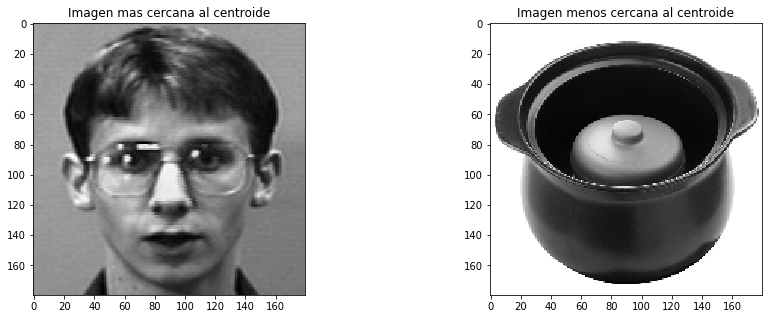

In [300]:
#menor y mayor distancias
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(np.reshape(data_set_aum_vec[:,df1.index[0]],(180,180)), cmap = plt.cm.gray) #check
axs[0].set_title('Imagen mas cercana al centroide')
#plt.show()

axs[1].imshow(np.reshape(data_set_aum_vec[:,df1.index[-1]],(180,180)), cmap = plt.cm.gray) #check
axs[1].set_title('Imagen menos cercana al centroide')
plt.show();